<a href="https://colab.research.google.com/github/27abernal/Adv_AI/blob/main/logistic_regression_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas scikit-learn

In [1]:
# Cell 1: Imports and File Upload
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import files

print("Upload Heart_Disease.csv:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Upload Heart_Disease.csv:


Saving Heart_Disease.csv to Heart_Disease.csv


In [2]:
# Cell 2: Data Loading and Preprocessing
# ================================
# Load data
df = pd.read_csv(filename)

# Drop education column
if 'education' in df.columns:
    df = df.drop(columns=['education'])

# Convert string columns to numeric
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values
df = df.dropna()

# Find target column
target_col = next((col for col in df.columns if 'CHD' in col.upper() or '10' in col), df.columns[-1])
print(f"Target column: {target_col}")

# Prepare features and target
X = df.drop(columns=[target_col])
y = df[target_col].values

# Convert categorical variables
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)

# Identify binary columns (0/1) to exclude from scaling
binary_columns = []
for col in X.columns:
    unique_vals = X[col].unique()
    if set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2:
        binary_columns.append(col)

print(f"Binary columns (won't scale): {binary_columns}")

# Feature scaling - only scale non-binary columns
scaler = StandardScaler()
if binary_columns:
    # Scale continuous columns only
    continuous_cols = [col for col in X.columns if col not in binary_columns]
    X_continuous_scaled = scaler.fit_transform(X[continuous_cols])

    # Combine scaled continuous with unscaled binary
    X_scaled = np.column_stack([X_continuous_scaled, X[binary_columns].values])

    # Recreate feature names in correct order
    feature_names = continuous_cols + binary_columns
else:
    X_scaled = scaler.fit_transform(X)
    feature_names = list(X.columns)

# Add bias column
X_with_bias = np.column_stack([np.ones(len(X_scaled)), X_scaled])

print(f"Data shape: {X_with_bias.shape}")
print(f"Class distribution: {np.bincount(y)}")

Target column: TenYearCHD
Binary columns (won't scale): ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
Data shape: (3749, 15)
Class distribution: [3177  572]


In [3]:
# Cell 3: Utility Functions
# ================================
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

def predict_proba(X, w):
    return sigmoid(X @ w)

def binary_cross_entropy(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

def gradient(X, y_true, y_prob):
    return (X.T @ (y_prob - y_true)) / len(y_true)

In [4]:
# Cell 4: Initialize Parameters and Print Starting Statistics
# ================================
# Initialize parameters with zeros
w_initial = np.zeros(X_with_bias.shape[1])

learning_rate = 0.05
num_iterations = 500

# Print starting statistics
print("=== STARTING STATISTICS ===")
print(f"Starting parameters: {w_initial}")
print(f"Learning rate: {learning_rate}, Iterations: {num_iterations}")

y_prob_initial = predict_proba(X_with_bias, w_initial)
initial_cost = binary_cross_entropy(y, y_prob_initial)
print(f"Starting cost: {initial_cost:.6f}")

=== STARTING STATISTICS ===
Starting parameters: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Learning rate: 0.05, Iterations: 500
Starting cost: 0.693147


In [5]:
# Cell 5: Gradient Descent Training
# ================================
w = w_initial.copy()
cost_history = []
w_history = []

print("Training...")
for i in range(num_iterations):
    y_prob = predict_proba(X_with_bias, w)
    cost = binary_cross_entropy(y, y_prob)
    cost_history.append(cost)

    # Store weights at quarter points
    if i in [0, num_iterations//4, num_iterations//2, 3*num_iterations//4]:
        w_history.append((i, w.copy()))

    grad = gradient(X_with_bias, y, y_prob)
    w = w - learning_rate * grad

# Store final weights
w_final = w.copy()
final_cost = cost_history[-1]
w_history.append((num_iterations, w_final))


print("Training completed!")

Training...
Training completed!


In [6]:
# Cell 6: Final Statistics
# ================================
print("\n=== FINAL STATISTICS ===")
print(f"Final parameters: {w_final}")
print(f"Final cost: {final_cost:.6f}")


=== FINAL STATISTICS ===
Final parameters: [-1.48079151e+00  4.79126607e-01  4.47466887e-01  6.20601048e-02
  3.11719032e-01  9.04780781e-02  3.82572133e-02 -4.95636189e-02
  1.83227169e-01 -1.02844478e-01 -4.34015918e-01 -1.19623374e-03
  1.40247781e-02 -1.96152473e-01 -1.15911207e-02]
Final cost: 0.387116


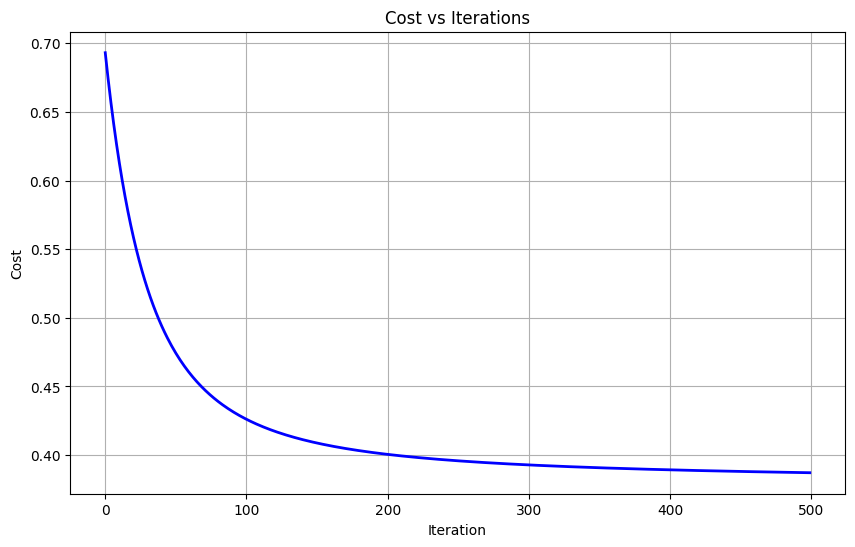

In [7]:
# Cell 7: Cost vs Iterations Plot
# ================================
plt.figure(figsize=(10, 6))
plt.plot(cost_history, 'b-', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs Iterations")
plt.grid(True)
plt.show()

Top 3 parameters: ['male', 'age', 'sysBP']


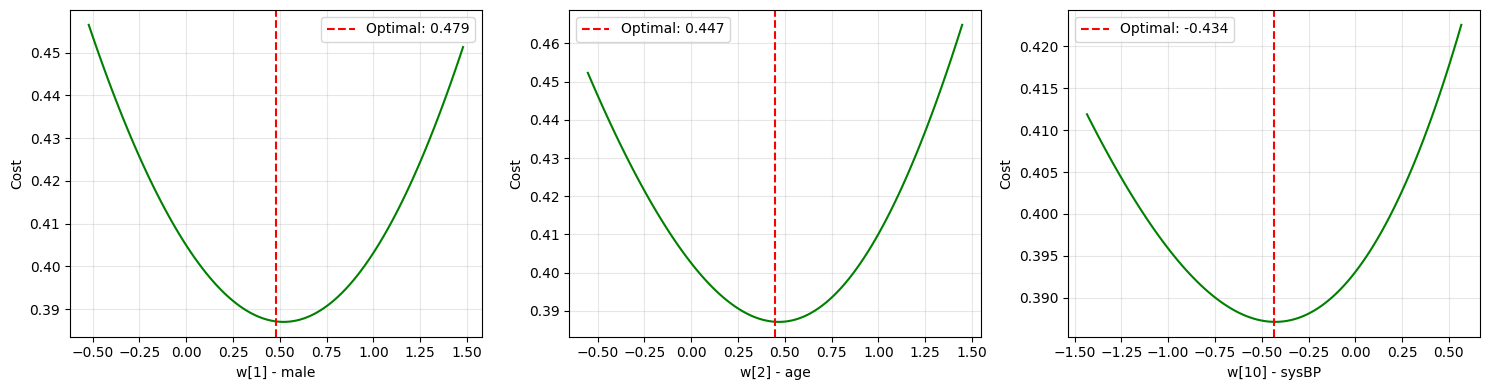

In [8]:
# Cell 8: Cost vs Parameters (Top 3)
# ================================
# Get top 3 parameters (excluding bias)
param_indices = np.argsort(np.abs(w_final[1:]))[::-1][:3] + 1
feature_names = list(X.columns)

print(f"Top 3 parameters: {[feature_names[i-1] for i in param_indices]}")

plt.figure(figsize=(15, 4))
for idx, param_idx in enumerate(param_indices):
    plt.subplot(1, 3, idx+1)

    center = w_final[param_idx]
    sweep = np.linspace(center-1.0, center+1.0, 100)
    costs = []

    for val in sweep:
        w_tmp = w_final.copy()
        w_tmp[param_idx] = val
        y_prob_tmp = predict_proba(X_with_bias, w_tmp)
        costs.append(binary_cross_entropy(y, y_prob_tmp))

    plt.plot(sweep, costs, 'g-')
    plt.axvline(center, color='r', linestyle='--', label=f'Optimal: {center:.3f}')
    plt.xlabel(f'w[{param_idx}] - {feature_names[param_idx-1]}')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Top 3 parameters: ['male', 'age', 'sysBP']


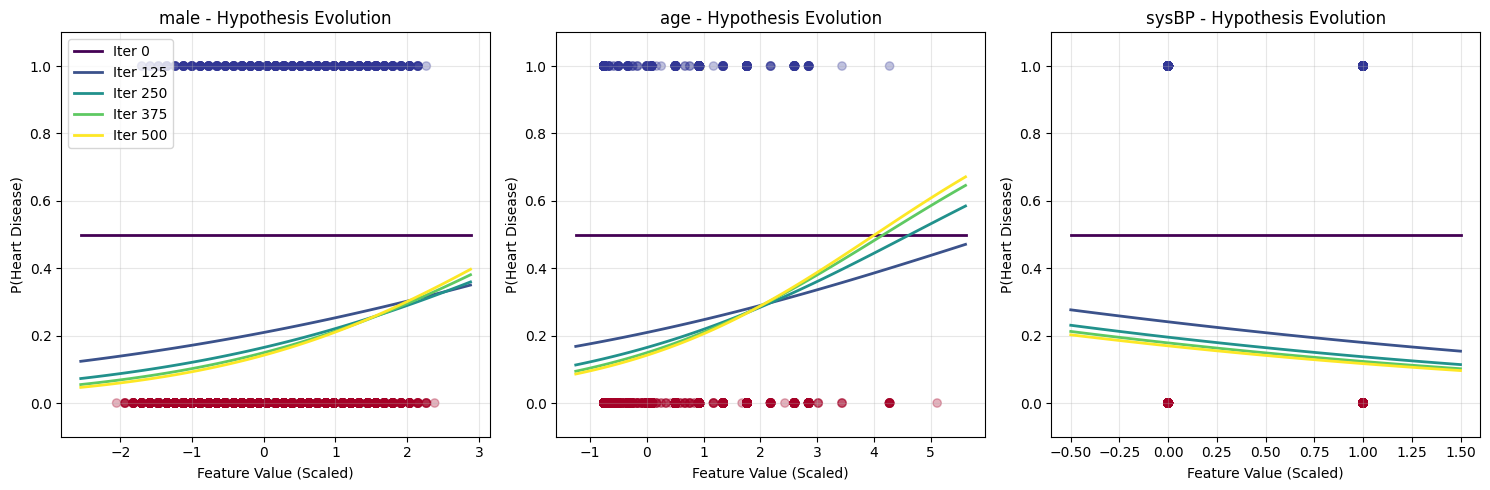

In [9]:
# Cell 9: Hypothesis Evolution - All Features on Single Graphs
# ================================
# Get top 3 parameters (excluding bias)
param_indices = np.argsort(np.abs(w_final[1:]))[::-1][:3] + 1
feature_names = list(X.columns)

print(f"Top 3 parameters: {[feature_names[i-1] for i in param_indices]}")

# Create one graph per feature showing evolution through all iterations
plt.figure(figsize=(15, 5))

# Color map for different iterations
colors = plt.cm.viridis(np.linspace(0, 1, len(w_history)))

for param_idx, (param_index, param_name) in enumerate(zip(param_indices, [feature_names[i-1] for i in param_indices])):
    plt.subplot(1, 3, param_idx + 1)

    # Create range for this feature
    x_range = np.linspace(X_scaled[:, param_index-1].min()-0.5,
                         X_scaled[:, param_index-1].max()+0.5, 100)

    # Plot each iteration
    for idx, (iter_num, w_current) in enumerate(w_history):
        # Create feature matrix: set all features to their mean except the current parameter
        X_test = np.full((100, X_scaled.shape[1]), X_scaled.mean(axis=0))
        X_test[:, param_index-1] = x_range

        # Add bias and predict
        X_test_with_bias = np.column_stack([np.ones(100), X_test])
        y_probs = predict_proba(X_test_with_bias, w_current)

        # Plot with color coding by iteration
        plt.plot(x_range, y_probs, color=colors[idx], linewidth=2,
                label=f'Iter {iter_num}' if param_idx == 0 else "")

    # Add data points
    plt.scatter(X_scaled[:, param_index-1], y, alpha=0.3, c=y, cmap='RdYlBu')
    plt.title(f'{param_name} - Hypothesis Evolution')
    plt.xlabel('Feature Value (Scaled)')
    plt.ylabel('P(Heart Disease)')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)

    # Add legend only to first subplot
    if param_idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

Top 3 parameters: ['male', 'age', 'sysBP']


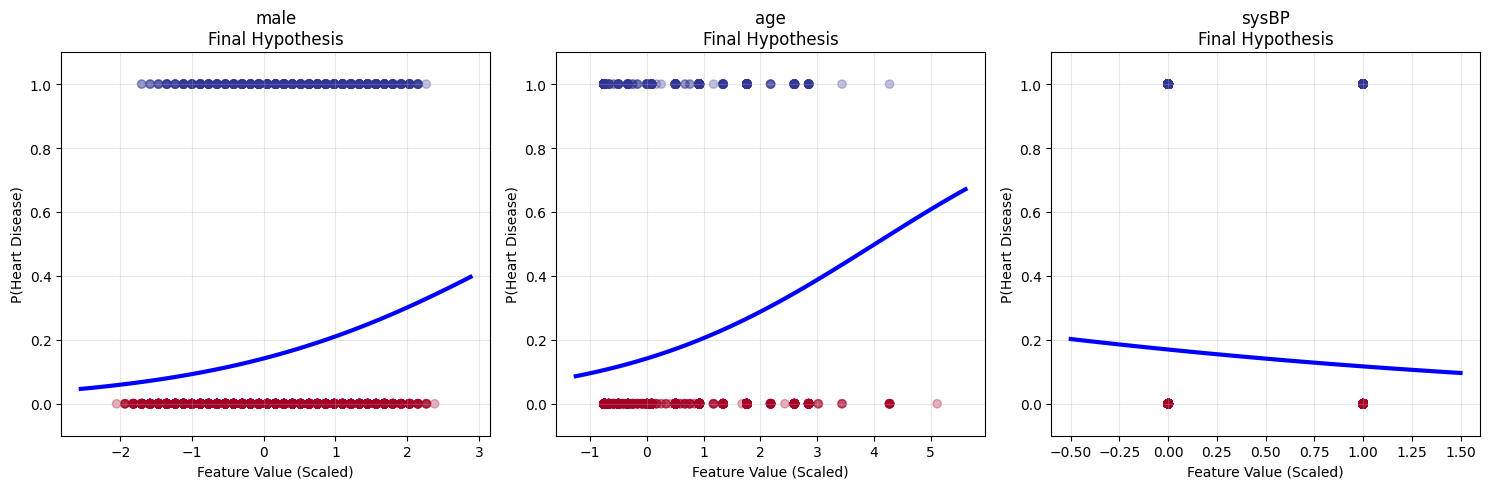

In [10]:
# Cell 10: Final Hypothesis for Top 3 Features
# ================================
# Get top 3 parameters (excluding bias)
param_indices = np.argsort(np.abs(w_final[1:]))[::-1][:3] + 1
feature_names = list(X.columns)

print(f"Top 3 parameters: {[feature_names[i-1] for i in param_indices]}")

# Create one graph per feature showing final hypothesis
plt.figure(figsize=(15, 5))

for param_idx, (param_index, param_name) in enumerate(zip(param_indices, [feature_names[i-1] for i in param_indices])):
    plt.subplot(1, 3, param_idx + 1)

    # Create range for this feature
    x_range = np.linspace(X_scaled[:, param_index-1].min()-0.5,
                         X_scaled[:, param_index-1].max()+0.5, 100)

    # Create feature matrix: set all features to their mean except the current parameter
    X_test = np.full((100, X_scaled.shape[1]), X_scaled.mean(axis=0))
    X_test[:, param_index-1] = x_range

    # Add bias and predict
    X_test_with_bias = np.column_stack([np.ones(100), X_test])
    y_probs = predict_proba(X_test_with_bias, w_final)

    # Plot final hypothesis
    plt.plot(x_range, y_probs, 'b-', linewidth=3, label='Final Hypothesis')

    # Add data points
    plt.scatter(X_scaled[:, param_index-1], y, alpha=0.3, c=y, cmap='RdYlBu')
    plt.title(f'{param_name}\nFinal Hypothesis')
    plt.xlabel('Feature Value (Scaled)')
    plt.ylabel('P(Heart Disease)')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()